# Equivalent Layer technique for estimating magnetization direction of a magnetized sphere

#### Importing libraries

In [1]:
% matplotlib inline 

In [2]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import cPickle as pickle
import datetime
import timeit
from scipy.optimize import nnls
from fatiando.gridder import regular
from fatiando.utils import ang2vec, vec2ang
from fatiando.mesher import Sphere, PointGrid,Prism
from fatiando.gravmag import sphere,prism
from fatiando.constants import CM, T2NT, G, SI2MGAL

/home/andrelreis/anaconda2/lib/python2.7/site-packages/fatiando/vis/mpl.py:76: UserWarning: This module will be removed in v0.6. We recommend the use of matplotlib.pyplot module directly. Some of the fatiando specific functions will remain.
  "specific functions will remain.")


In [3]:
notebook_name = 'airborne_EQL_magdirection.ipynb'

### Gray background figures

In [4]:
plt.style.use('grayscale')

#### Importing auxiliary functions

In [5]:
dir_modules = '../'
sys.path.append(dir_modules)

In [6]:
import eql_functions as func

In [7]:
import auxiliary_functions as fc

#### Loading properties of the model

In [8]:
with open('data/model_sphere_remanent.pickle') as f:
        model_sphere_remanent = pickle.load(f)

In [9]:
with open('data/model_sphere_induced.pickle') as f:
        model_sphere_induced = pickle.load(f)

#### Loading properties grid

In [10]:
with open('data/airborne_survey.pickle') as f:
        airborne = pickle.load(f)

#### Loading data

In [11]:
with open('data/data_set.pickle') as f:
        data = pickle.load(f)

#### Open a dictionary

In [12]:
dir_sphere = dict()

### Saving files

In [13]:
saved_files = []

## Observation area

In [14]:
print 'Area limits: \n x_max = %.1f m \n x_min = %.1f m \n y_max = %.1f m \n y_min = %.1f m' % (airborne['area'][1], 
                                                                                                airborne['area'][0],
                                                                                                airborne['area'][3],
                                                                                                airborne['area'][2])

Area limits: 
 x_max = 5000.0 m 
 x_min = -5000.0 m 
 y_max = 5000.0 m 
 y_min = -5000.0 m


### Airborne survey information

In [15]:
print 'Shape : (%.0f,%.0f)'% airborne['shape'] 
print 'Number of data: %.1f' % airborne['N']
print 'dx: %.1f m' % airborne['dx']
print 'dy: %.1f m ' % airborne['dy']

Shape : (50,20)
Number of data: 1000.0
dx: 204.1 m
dy: 526.3 m 


## Properties of the model

### Dimension and coordinate of the center

In [16]:
print 'Properties Sphere:\n xc = %.1f m \n yc = %.1f m \n zc = %.1f m \n radius = %.1f m ' %  (model_sphere_remanent['xc'],
                                                                                               model_sphere_remanent['yc'],
                                                                                               model_sphere_remanent['zc'],
                                                                                               model_sphere_remanent['radius'])

Properties Sphere:
 xc = 0.0 m 
 yc = 0.0 m 
 zc = 2000.0 m 
 radius = 1500.0 m 


### Main field

In [17]:
inc_gf,dec_gf = model_sphere_remanent['main_field']

In [18]:
print'Main field inclination: %.1f degree' % inc_gf
print'Main field declination: %.1f degree' % dec_gf

Main field inclination: 40.0 degree
Main field declination: 45.0 degree


### Magnetization direction

In [19]:
print 'Intensity: %.1f A/m' % model_sphere_remanent['m_R']
print 'Inclination: %.1f degree' % model_sphere_remanent['inc_R']
print 'Declination: %.1f degree' % model_sphere_remanent['dec_R']

Intensity: 15.0 A/m
Inclination: 60.0 degree
Declination: 10.0 degree


In [20]:
inc_R,dec_R = model_sphere_remanent['inc_R'],model_sphere_remanent['dec_R']

## Generating the layer with my function 

In [21]:
h = 1900.

#### Generating a layer

In [22]:
shape_layer = (50,20)

In [23]:
xs,ys,zs = regular(airborne['area'],shape_layer,h)

## Non-negative Least Squares Method for estimating a positive layer

In [24]:
G = fc.sensitivity_mag(airborne['x'],airborne['y'],airborne['z'],
                       xs,ys,zs,inc_gf,dec_gf,inc_R,dec_R)

In [25]:
start_time = timeit.default_timer()

In [26]:
m_pos,_ = nnls(G,data['tfa_obs_sphere_RM_airb'])

In [27]:
elapsed = timeit.default_timer() - start_time

In [28]:
print elapsed

0.354113101959


In [30]:
tf_pred_pos = fc.tfa_layer(airborne['x'],airborne['y'],airborne['z'],
                           xs,ys,zs,inc_gf,dec_gf,m_pos,inc_R,dec_R)

### Calculating residual

In [31]:
r_pos = data['tfa_obs_sphere_RM_airb'] - tf_pred_pos

#### Parameters for normalized histogram

In [32]:
r_norm,r_mean,r_std = func.residual(data['tfa_obs_sphere_RM_airb'],tf_pred_pos)

In [33]:
print r_mean

-0.343488036316


## Comparison between the Model and the Layer with posivity

/home/andrelreis/anaconda2/lib/python2.7/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


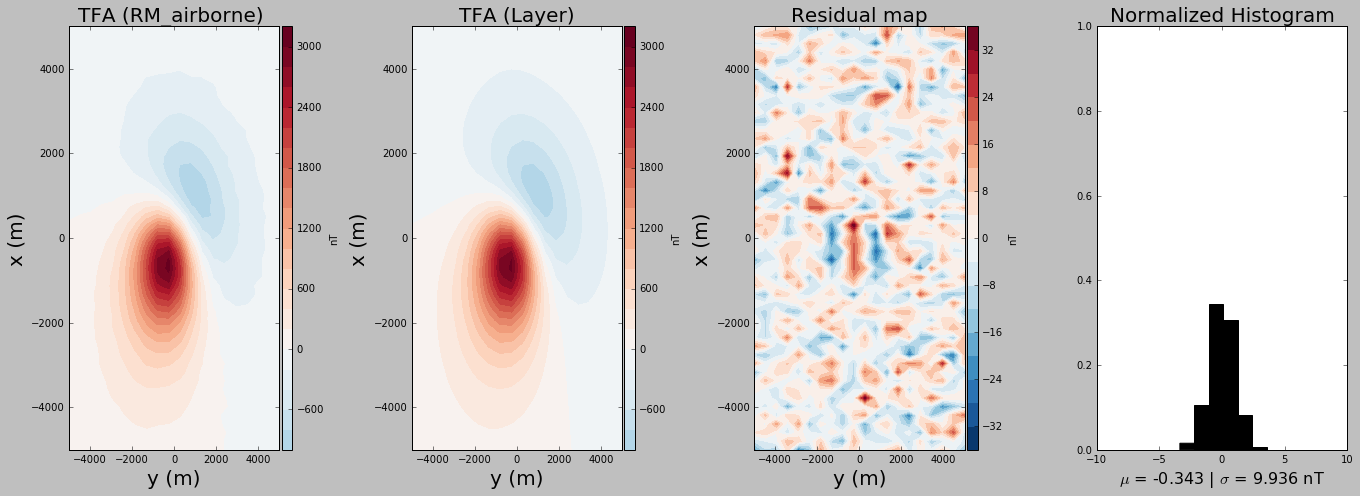

In [34]:
title_font = 20
bottom_font = 16
saturation_factor = 1.
plt.close('all')
plt.figure(figsize=(19,7), tight_layout=True)

ranges = saturation_factor*np.abs([data['tfa_obs_sphere_RM_airb'].max(), 
                                   data['tfa_obs_sphere_RM_airb'].min(),
                                   tf_pred_pos.max(), tf_pred_pos.min()]).max()

r_ranges = saturation_factor*np.abs([r_pos.max(), r_pos.min()]).max()

plt.subplot(1,4,1)
plt.contourf(airborne['y'].reshape(airborne['shape']),
             airborne['x'].reshape(airborne['shape']), 
             data['tfa_obs_sphere_RM_airb'].reshape(airborne['shape']),
             20, cmap='RdBu_r',vmin=-ranges, vmax=ranges)
plt.colorbar(pad=0.01, aspect=40, shrink=1.0).set_label('nT')
plt.xlabel('y (m)', fontsize = title_font)
plt.ylabel('x (m)', fontsize = title_font)
plt.title('TFA (RM_airborne) ', fontsize=title_font)

plt.subplot(1,4,2)
plt.contourf(airborne['y'].reshape(airborne['shape']),
             airborne['x'].reshape(airborne['shape']),
             tf_pred_pos.reshape(airborne['shape']),
             20, cmap='RdBu_r',  vmin=-ranges, vmax=ranges)
plt.colorbar(pad=0.01, aspect=40, shrink=1.0).set_label('nT')
plt.xlabel('y (m)', fontsize = title_font)
plt.ylabel('x (m)', fontsize = title_font)
plt.title('TFA (Layer)', fontsize=title_font)

plt.subplot(1,4,3)
plt.contourf(airborne['y'].reshape(airborne['shape']),
             airborne['x'].reshape(airborne['shape']),
             r_pos.reshape(airborne['shape']), 
             20, cmap='RdBu_r',  vmin=-r_ranges, vmax=r_ranges)
plt.colorbar(pad=0.01, aspect=40, shrink=1.0).set_label('nT')
plt.xlabel('y (m)', fontsize = title_font)
plt.ylabel('x (m)', fontsize = title_font)
plt.title('Residual map', fontsize=title_font)


plt.subplot(1,4,4)
plt.xlabel('$\mu$ = %.3f | $\sigma$ = %.3f nT' % (r_mean, r_std),
           fontsize = bottom_font)
nbins = int((np.max(r_norm - np.min(r_norm))))
plt.hist(r_norm,bins=nbins,normed=True)
plt.ylim(0.,1.)
plt.xlim(-10., 10.)
plt.title('Normalized Histogram',fontsize=title_font)

file_name = 'figs/airborne/noisy_data_fitting_NNLS_magRM'
plt.savefig(file_name+'.png',dpi=200)
saved_files.append(file_name+'.png')

plt.show()

### Magnetic moment within the Layer with positivity constraint

<function matplotlib.pyplot.show>

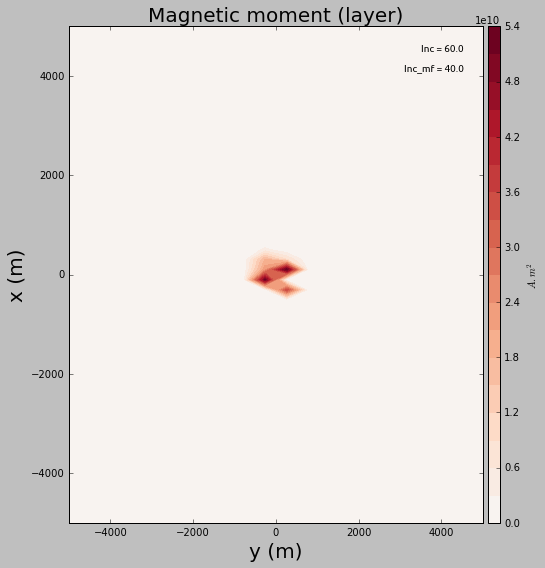

In [36]:
title_font = 20
bottom_font = 16
saturation_factor = 1.
plt.close('all')
plt.figure(figsize=(8,8), tight_layout=True)

ranges = saturation_factor*np.abs([m_pos.max(), m_pos.min()]).max()

plt.contourf(ys.reshape(shape_layer),
             xs.reshape(shape_layer), 
             m_pos.reshape(shape_layer),
             20, cmap='RdBu_r',vmin=-ranges, vmax=ranges)
plt.colorbar(pad=0.01, aspect=40, shrink=1.0).set_label('$A.m^2$')
plt.xlabel('y (m)', fontsize = title_font)
plt.ylabel('x (m)', fontsize = title_font)
plt.title('Magnetic moment (layer)', fontsize=title_font)
plt.text(3500.,4500.,'Inc = %.1f'% inc_R,family='ubuntu',style='normal')
plt.text(3100.,4100.,'Inc_mf = %.1f'% inc_gf,family='ubuntu',style='normal' )

file_name = 'figs/airborne/noisy_magnetic_moment_positive_NNLS_magRM'
plt.savefig(file_name+'.png',dpi=200)
saved_files.append(file_name+'.png')

plt.show

### Levenberg-Marquardt with NNLS for positive magnetic moments

In [37]:
i_pos = 1500

In [38]:
it_max = 30

In [39]:
it_marq = 15

In [40]:
eps = 1e-4

In [41]:
lamb = 10.
dlamb = 100.

In [42]:
m_LM,inc_est,dec_est,phi,imax,pest,incs,decs = fc.levenberg_marquardt_NNLS(
    data['tfa_obs_sphere_RM_airb'],airborne['x'],airborne['y'],airborne['z'],
    xs,ys,zs,inc_gf,dec_gf,-10.,15.,lamb,dlamb,i_pos,it_max,
    it_marq,eps)

i = 0
5.80075951902 16.8712812145
0.831645582138
i = 1
11.2854899187 17.3696057672
0.502009451532
i = 2
14.5220298217 17.9756721721
0.281438471011
i = 3
16.8772821543 18.5303273169
0.203094801024
i = 4
18.7213368884 19.0505549349
0.158546722369
i = 5
20.2214697981 19.5351642844
0.127441397781
i = 6
21.4777136589 19.9748973929
0.104647966782
i = 7
22.5532207699 20.3723729042
0.0875009083617
i = 8
23.4890674318 20.7287830632
0.0741055402037
i = 9
24.3250222664 21.0661782939
0.0655661218529
i = 10
25.077923983 21.3799631984
0.058134504042
i = 11
25.7623518053 21.6767897236
0.0520875329869
i = 12
26.3902227093 21.9627965555
0.0472867278376
i = 13
26.9693540006 22.2385544549
0.0431340002965
i = 14
27.5058080465 22.5044411799
0.0394447015583
i = 15
28.006170289 22.7607595383
0.0363399319687
i = 16
28.4736368788 23.0052088106
0.0333756204811
i = 17
28.9111383372 23.2372632363
0.0306042943897
i = 18
29.3216440001 23.4570710852
0.0280721747641
i = 19
29.7077860668 23.6643313724
0.0257488625839


### Visualization of the convergence

In [43]:
phi = np.array(phi)/airborne['x'].size

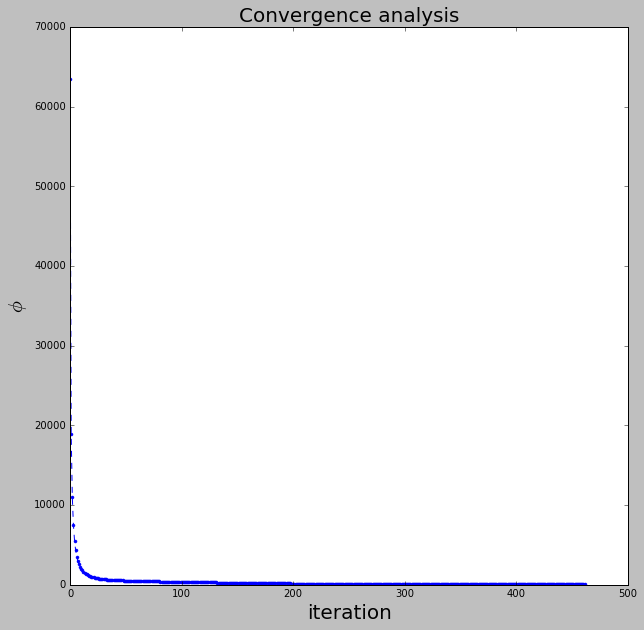

In [44]:
title_font = 20
bottom_font = 16
saturation_factor = 1.
plt.close('all')
plt.figure(figsize=(8,8), tight_layout=True)

plt.figure(figsize=(10, 10))
plt.plot(phi, 'b--')
plt.plot(phi, 'b.')

plt.title('Convergence analysis', fontsize=title_font)
plt.xlabel('iteration', fontsize = title_font)
plt.ylabel('$\phi$', fontsize = title_font)

file_name = 'figs/airborne/noisy_convergence_LM_NNLS_magRM'
plt.savefig(file_name+'.png',dpi=200)
saved_files.append(file_name+'.png')

plt.show()

### Estimated magnetization direction

In [45]:
print (inc_est,dec_est)

(58.767726958663012, 11.824988938944838)


In [47]:
print (inc_R,dec_R)

(60.0, 10.0)


### Comparison between observed data and predicted data

In [48]:
pred = fc.tfa_layer(airborne['x'],airborne['y'],airborne['z'],
                    xs,ys,zs,inc_gf,dec_gf,m_LM,inc_est,dec_est)

In [49]:
res = pred - data['tfa_obs_sphere_RM_airb']

In [50]:
r_norm,r_mean,r_std = func.residual(data['tfa_obs_sphere_RM_airb'],pred)

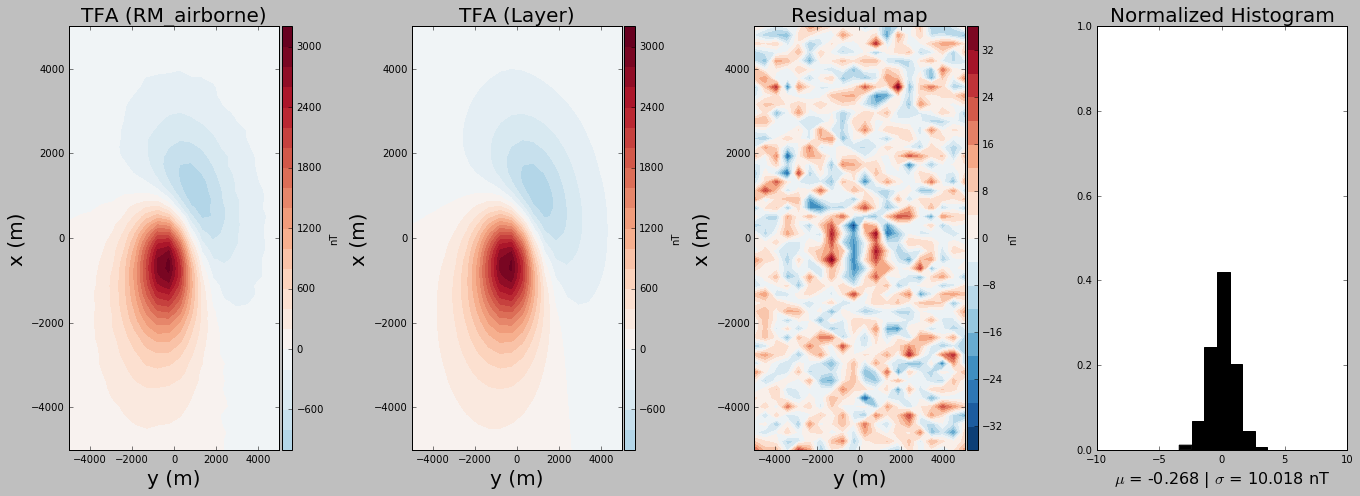

In [51]:
title_font = 20
bottom_font = 16
saturation_factor = 1.
plt.close('all')
plt.figure(figsize=(19,7), tight_layout=True)

ranges = saturation_factor*np.abs([data['tfa_obs_sphere_RM_airb'].max(), 
                                   data['tfa_obs_sphere_RM_airb'].min(),
                                   pred.max(), pred.min()]).max()
res_ranges = np.max(np.abs(res))

plt.subplot(1,4,1)
plt.contourf(airborne['y'].reshape(airborne['shape']),
             airborne['x'].reshape(airborne['shape']), 
             data['tfa_obs_sphere_RM_airb'].reshape(airborne['shape']),
             20, cmap='RdBu_r',vmin=-ranges, vmax=ranges)
plt.colorbar(pad=0.01, aspect=40, shrink=1.0).set_label('nT')
plt.xlabel('y (m)', fontsize = title_font)
plt.ylabel('x (m)', fontsize = title_font)
plt.title('TFA (RM_airborne)',fontsize=title_font)

plt.subplot(1,4,2)
plt.contourf(airborne['y'].reshape(airborne['shape']),
             airborne['x'].reshape(airborne['shape']),
             pred.reshape(airborne['shape']),
             20, cmap='RdBu_r',  vmin=-ranges, vmax=ranges)
plt.colorbar(pad=0.01, aspect=40, shrink=1.0).set_label('nT')
plt.xlabel('y (m)', fontsize = title_font)
plt.ylabel('x (m)', fontsize = title_font)
plt.title('TFA (Layer)', fontsize=title_font)

plt.subplot(1,4,3)
plt.contourf(airborne['y'].reshape(airborne['shape']),
             airborne['x'].reshape(airborne['shape']),
             res.reshape(airborne['shape']), 
             20, cmap='RdBu_r',  vmin=-res_ranges, vmax=res_ranges)
plt.colorbar(pad=0.01, aspect=40, shrink=1.0).set_label('nT')
plt.xlabel('y (m)', fontsize = title_font)
plt.ylabel('x (m)', fontsize = title_font)
plt.title('Residual map', fontsize=title_font)


plt.subplot(1,4,4)
plt.xlabel('$\mu$ = %.3f | $\sigma$ = %.3f nT' % (r_mean, r_std),
           fontsize = bottom_font)
nbins = int((np.max(r_norm - np.min(r_norm))))
plt.hist(r_norm,bins=nbins,normed=True)
plt.ylim(0.,1.)
plt.xlim(-10., 10.)
plt.title('Normalized Histogram',fontsize=title_font)

file_name = 'figs/airborne/noisy_data_fitting_LM_NNLS_magRM'
plt.savefig(file_name+'.png',dpi=200)
saved_files.append(file_name+'.png')

plt.show()

### Estimated magnetic moment within the layer

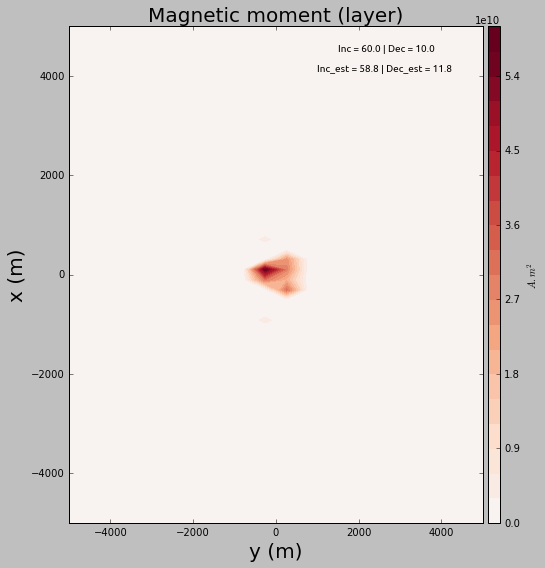

In [52]:
title_font = 20
bottom_font = 16
saturation_factor = 1.
plt.close('all')
plt.figure(figsize=(8,8), tight_layout=True)

ranges = saturation_factor*np.abs([m_LM.max(), m_LM.min()]).max()

plt.contourf(ys.reshape(shape_layer),
             xs.reshape(shape_layer), 
             m_LM.reshape(shape_layer),
             20, cmap='RdBu_r',vmin=-ranges, vmax=ranges)
plt.colorbar(pad=0.01, aspect=40, shrink=1.0).set_label('$A.m^2$')
plt.xlabel('y (m)', fontsize = title_font)
plt.ylabel('x (m)', fontsize = title_font)
plt.title('Magnetic moment (layer)', fontsize=title_font)
plt.text(1500.,4500.,'Inc = %.1f | Dec = %.1f '% (inc_R,dec_R),family='ubuntu',style='normal')
plt.text(1000.,4100.,'Inc_est = %.1f | Dec_est = %.1f '% (inc_est,dec_est),family='ubuntu',style='normal' )

file_name = 'figs/airborne/noisy_magnetic_moment_positive_LM_NNLS_magRM'
plt.savefig(file_name+'.png',dpi=200)
saved_files.append(file_name+'.png')

plt.show()

### Reduction to the pole

In [53]:
G_rtp = fc.sensitivity_mag(airborne['x'],airborne['y'],airborne['z'],
                       xs,ys,zs,90.,0.,90.,0.)

In [54]:
tfa_rtp = np.dot(G_rtp,m_LM)

#### Visualization of a reduction to the pole

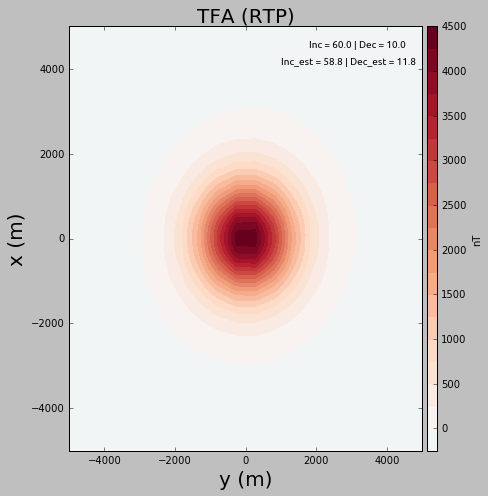

In [55]:
title_font = 20
bottom_font = 16
saturation_factor = 1.
plt.close('all')
plt.figure(figsize=(7,7), tight_layout=True)

ranges = saturation_factor*np.abs([tfa_rtp.max(), tfa_rtp.min()]).max()

plt.contourf(airborne['y'].reshape(airborne['shape']), 
             airborne['x'].reshape(airborne['shape']),
             tfa_rtp.reshape(airborne['shape']), 
             20, cmap='RdBu_r',vmin=-ranges, vmax=ranges)
plt.colorbar(pad=0.01, aspect=40, shrink=1.0).set_label('nT')
plt.xlabel('y (m)', fontsize = title_font)
plt.ylabel('x (m)', fontsize = title_font)
plt.title('TFA (RTP)', fontsize=title_font)
plt.text(1800.,4500.,'Inc = %.1f | Dec = %.1f'% (inc_R,dec_R), 
         family='ubuntu',style='normal')
plt.text(1000.,4100.,'Inc_est = %.1f | Dec_est = %.1f'% (inc_est,dec_est), 
         family='ubuntu',style='normal' )


file_name = 'figs/airborne/RTP_airborne_magRM'
plt.savefig(file_name+'.png',dpi=200)
saved_files.append(file_name+'.png')


plt.show()